In [1]:
input_dim = 100
model_file = "model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt"
num_clusters = 4

import json
import matplotlib.pyplot as plt
from matplotlib.path import Path
import numpy as np
import pandas as pd
import tensorflow as tf

import sys
sys.path.insert(0, "../Code/")
from load import load_original, load_vae_sym

def load_model(num_points, input_dim = input_dim, model_file = model_file):
    return load_vae_sym(input_dim, model_file, num_points)

from explain import explain_sym

import os
os.system("rm -rf tb")

0

In [2]:
###
# Load Data & Configuration
###

x = pd.read_csv("bipolar.tsv", sep="\t").values

with open("vertices.json") as json_file:  
    all_vertices = json.load(json_file)

batch_size = 20

INFO:tensorflow:Restoring parameters from model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


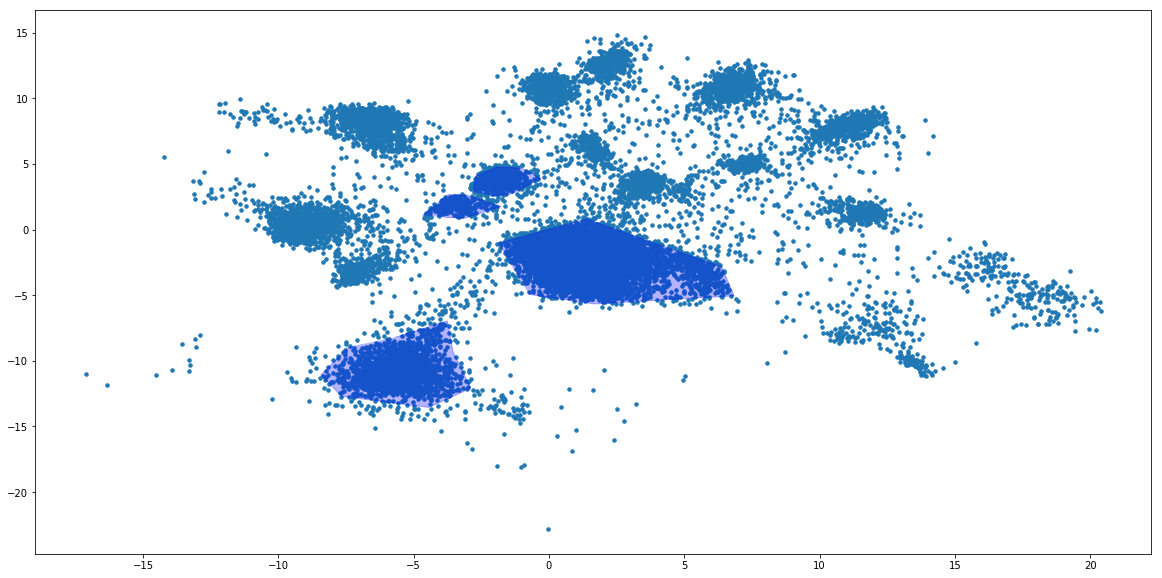

In [3]:
###
# Visualize the data and the marked clusters
###

sess, rep, X = load_original(input_dim, model_file)

data_rep = sess.run(rep, feed_dict={X: x})

fig, ax = plt.subplots(figsize=(20, 10))
patches = []

for i in range(num_clusters):
    line = plt.Polygon(all_vertices[i], closed=False, color="blue", alpha=0.3)
    ax.add_line(line)

plt.scatter(data_rep[:, 0], data_rep[:, 1], s = 12)

plt.show()
plt.close()



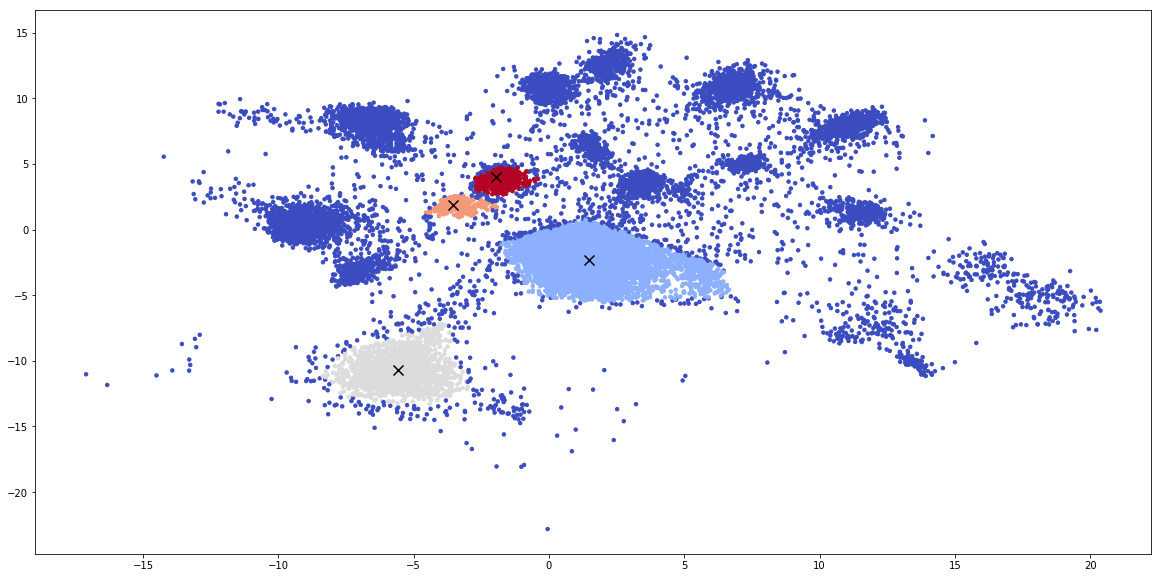

In [4]:
###
# Find the datapoints in each marked cluster
###

m = data_rep.shape[0]
cluster = -1.0 * np.ones((m))
indices = [[]] * num_clusters
centers = [[]] * num_clusters
for i in range(num_clusters):
    path = Path(all_vertices[i])
    indices[i] = []
    for j in range(m):
        if path.contains_points(data_rep[j].reshape((1,2))):
            cluster[j] = i
            indices[i].append(j)
    centers[i] = np.mean(data_rep[indices[i], :], axis = 0)
    
centers = np.array(centers)

fig, ax = plt.subplots(figsize=(20, 10))
patches = []
    
plt.scatter(data_rep[:, 0], data_rep[:, 1], s = 12, c = cluster, cmap = plt.cm.coolwarm)
plt.scatter(centers[:, 0], centers[:, 1], c = "black", marker = "x", s = 100)

plt.show()
plt.close()
        

INFO:tensorflow:Restoring parameters from model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


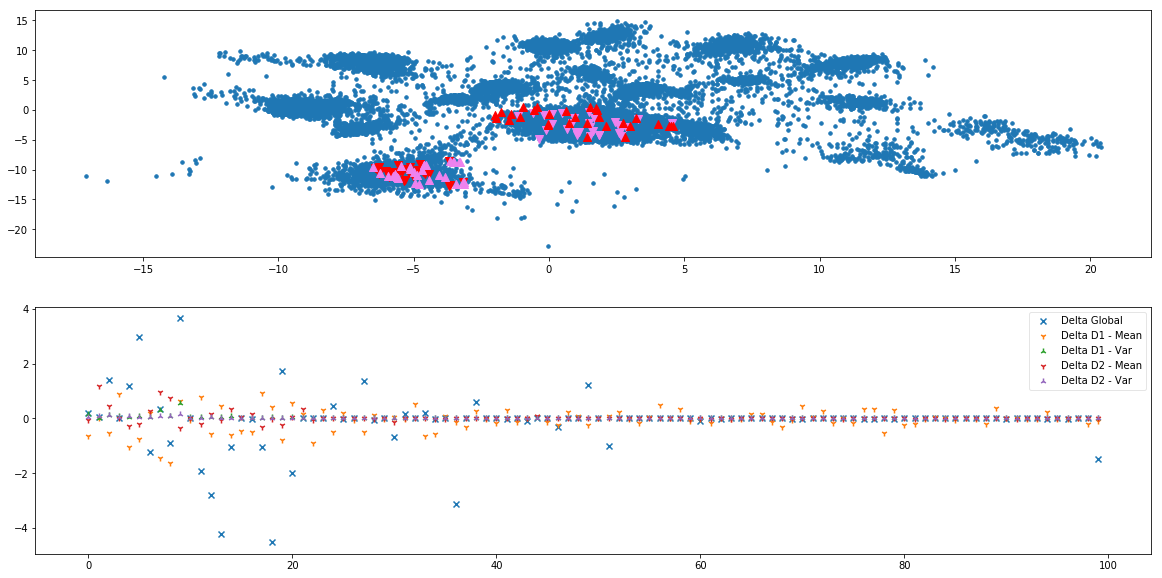

In [5]:
global_0_1, _, _ = explain_sym(load_model, x, data_rep, indices, 0, 1, dispersion_c1 = 10.0, dispersion_c2 = 2.0, lambda_global = 3.0, lambda_ind = 10.0)


INFO:tensorflow:Restoring parameters from model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


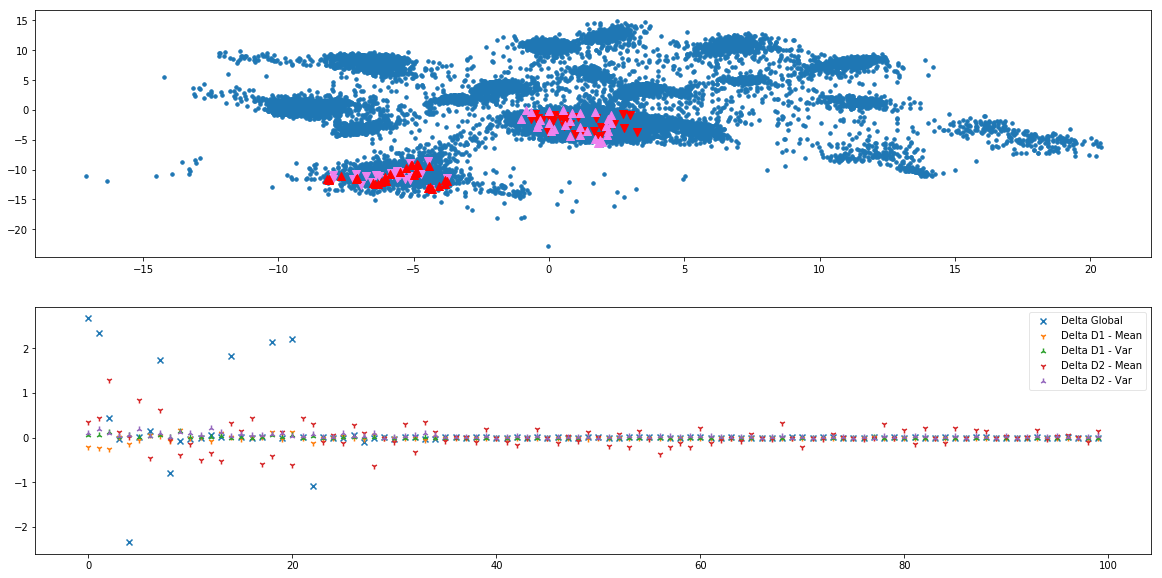

In [6]:
global_1_0, _, _ = explain_sym(load_model, x, data_rep, indices, 1, 0, dispersion_c1 = 2.0, dispersion_c2 = 10.0, lambda_global = 3.0, lambda_ind = 10.0)


INFO:tensorflow:Restoring parameters from model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


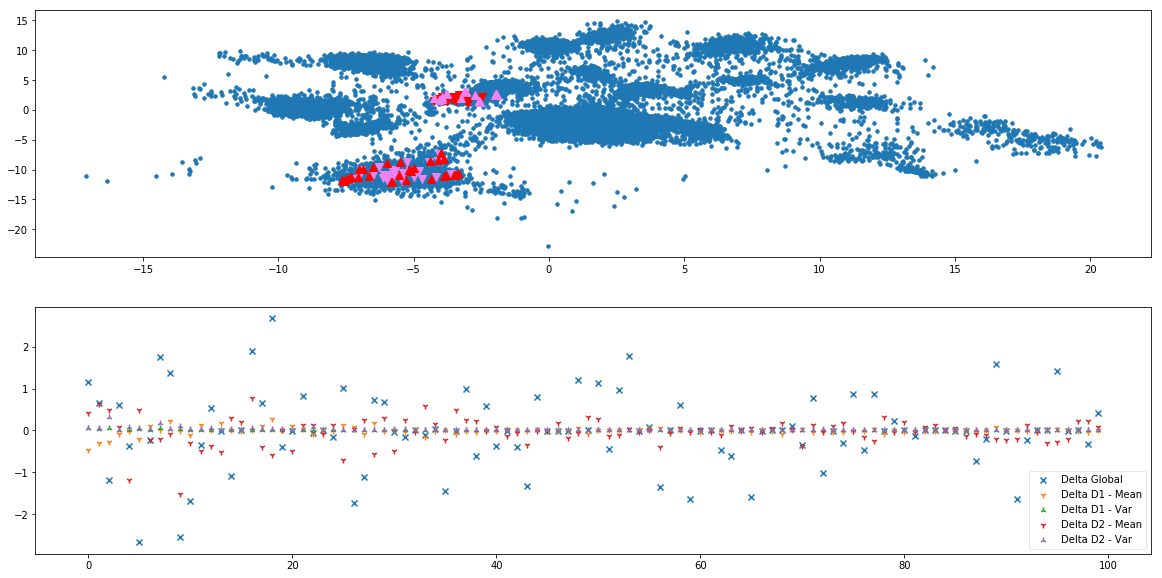

In [7]:
global_1_2, _, _ = explain_sym(load_model, x, data_rep, indices, 1, 2, dispersion_c1 = 2.0, dispersion_c2 = 1.0, lambda_global = 0.5, lambda_ind = 1.0)


INFO:tensorflow:Restoring parameters from model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


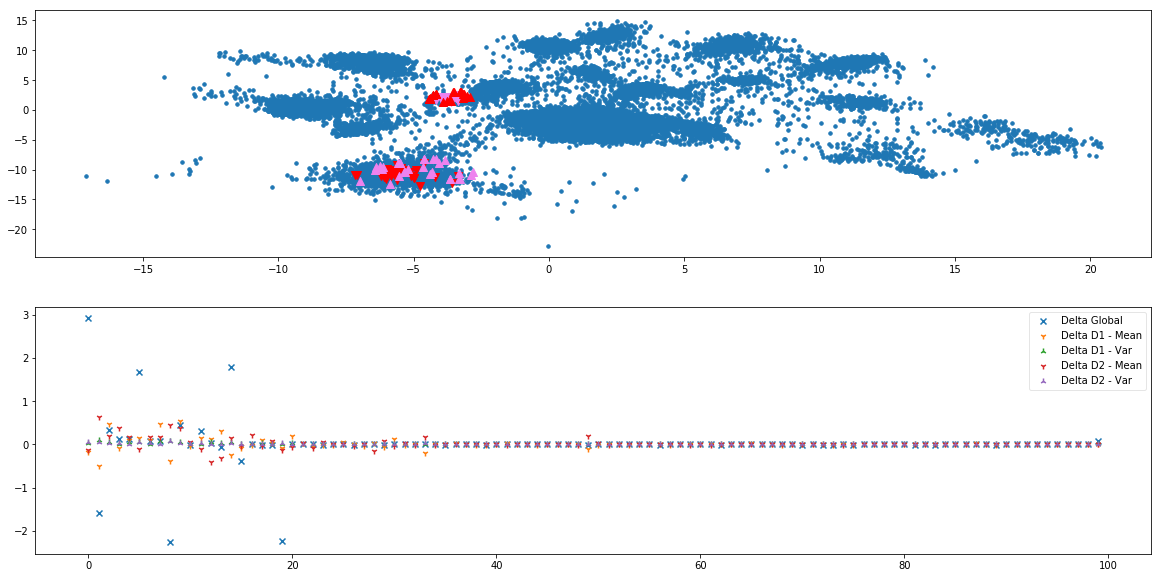

In [8]:
global_2_1, _, _ = explain_sym(load_model, x, data_rep, indices, 2, 1, dispersion_c1 = 1.0, dispersion_c2 = 2.0, lambda_global = 3.0, lambda_ind = 10.0)


INFO:tensorflow:Restoring parameters from model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


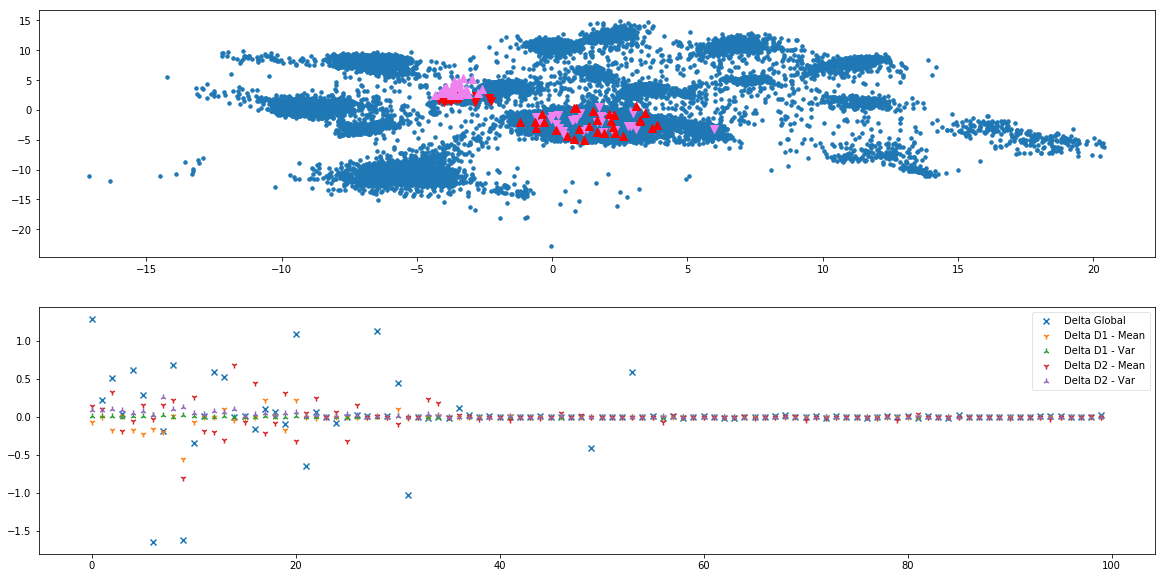

In [9]:
global_0_2, _, _ = explain_sym(load_model, x, data_rep, indices, 0, 2, dispersion_c1 = 10.0, dispersion_c2 = 1.0, lambda_global = 3.0, lambda_ind = 10.0)


INFO:tensorflow:Restoring parameters from model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


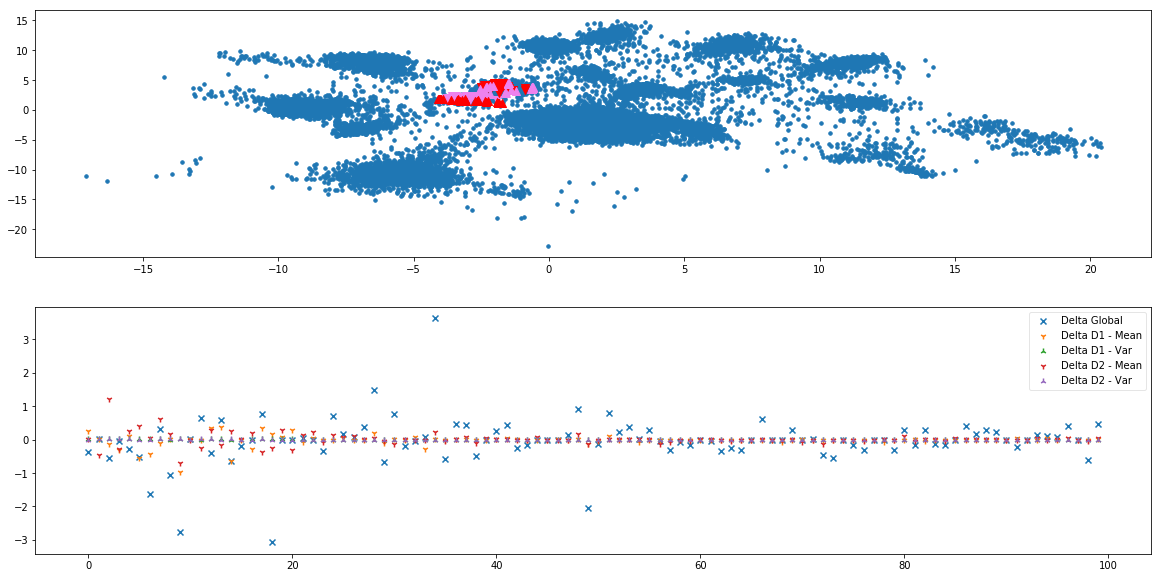

In [13]:
_, _, _ = explain_sym(load_model, x, data_rep, indices, 2, 3, dispersion_c1 = 1.0, dispersion_c2 = 1.0, lambda_global = 3.0, lambda_ind = 5.0)

In [11]:
def scale(a2b, b2a):
    return (a2b + b2a) / (0.5 * np.sum(np.abs(a2b)) + 0.5 * np.sum(np.abs(b2a)))

In [14]:
print("From 0 to 1 and then 1 to 0")
print(np.round(scale(global_0_1, global_1_0), 3))
print("From 1 to 2 and then 2 to 1")
print(np.round(scale(global_1_2, global_2_1), 3))
print("From 0 to 1 and then 1 to 2 compared to from 0 to 2")
print(np.round(scale(global_0_2, -1.0 * (global_0_1 + global_1_2)), 3))

From 0 to 1 and then 1 to 0
[[ 0.094  0.079  0.061 -0.001 -0.037  0.098 -0.036  0.068 -0.056  0.118
  -0.001 -0.064 -0.09  -0.138  0.025  0.002 -0.001 -0.034 -0.078  0.057
   0.006  0.001 -0.035  0.     0.015 -0.001  0.002  0.042 -0.003  0.
  -0.024  0.006  0.     0.005 -0.002  0.    -0.102 -0.     0.02   0.
   0.    -0.     0.    -0.003  0.    -0.    -0.01  -0.    -0.     0.041
   0.    -0.033 -0.     0.     0.     0.     0.    -0.     0.     0.
  -0.003 -0.    -0.     0.    -0.     0.    -0.    -0.    -0.     0.
  -0.    -0.     0.     0.    -0.     0.    -0.    -0.    -0.     0.
  -0.     0.    -0.     0.     0.    -0.    -0.     0.     0.     0.
  -0.    -0.    -0.     0.    -0.    -0.    -0.    -0.    -0.    -0.049]]
From 1 to 2 and then 2 to 1
[[ 0.111 -0.026 -0.023  0.02  -0.006 -0.027 -0.004  0.05  -0.024 -0.057
  -0.046 -0.001  0.016 -0.002  0.019 -0.01   0.052  0.018  0.072 -0.071
  -0.     0.022 -0.002 -0.    -0.004  0.028 -0.048 -0.03   0.02   0.019
  -0.001 -0.004  0.    -